## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 預防錯誤： OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

# 三層隱藏層，一個輸出層(softmax)
def build_mlp(input_shape, output_units=10):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Dense(units=512, activation="relu", name="hidden_layer_0")(input_layer)
    x = BatchNormalization()(x)
    x = keras.layers.Dense(units=256, activation="relu", name="hidden_layer_1")(x)
    x = BatchNormalization()(x)
    x = keras.layers.Dense(units=128, activation="relu", name="hidden_layer_2")(x)
    x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

### EarlyStopping的参数

- monitor: 监控的数据接口，有’acc’,’val_acc’,’loss’,’val_loss’等等。正常情况下如果有验证集，就用’val_acc’或者’val_loss’。但是因为笔者用的是5折交叉验证，没有单设验证集，所以只能用’acc’了。
- min_delta：增大或减小的阈值，只有大于这个部分才算作improvement。这个值的大小取决于monitor，也反映了你的容忍程度。例如笔者的monitor是’acc’，同时其变化范围在70%-90%之间，所以对于小于0.01%的变化不关心。加上观察到训练过程中存在抖动的情况（即先下降后上升），所以适当增大容忍程度，最终设为0.003%。
- patience：能够容忍多少个epoch内都没有improvement。这个设置其实是在抖动和真正的准确率下降之间做tradeoff。如果patience设的大，那么最终得到的准确率要略低于模型可以达到的最高准确率。如果patience设的小，那么模型很可能在前期抖动，还在全图搜索的阶段就停止了，准确率一般很差。patience的大小和learning rate直接相关。在learning rate设定的情况下，前期先训练几次观察抖动的epoch number，比其稍大些设置patience。在learning rate变化的情况下，建议要略小于最大的抖动epoch number。笔者在引入EarlyStopping之前就已经得到可以接受的结果了，EarlyStopping算是锦上添花，所以patience设的比较高，设为抖动epoch number的最大值。
- mode: 就’auto’, ‘min’, ‘,max’三个可能。如果知道是要上升还是下降，建议设置一下。笔者的monitor是’acc’，所以mode=’max’。


In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""

from keras.callbacks import EarlyStopping


"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
def run_model(results: dict, patience = 5):
    earlystop = EarlyStopping(monitor="val_acc", 
                          patience=patience, 
                          verbose=1
                          )
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "patience-{}".format(str(patience))

    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

In [9]:
results = {}
patiences = [5, 10, 25]

for patience in patiences:
    run_model(results, patience)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

Epoch 12/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.2445 - acc: 0.5691 - val_loss: 1.4950 - val_acc: 0.4785
Epoch 13/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.2200 - acc: 0.5796 - val_loss: 1.4767 - val_acc: 0.4837
Epoch 14/50
50000/50000 [==============================] - 10s 208us/step - loss: 1.1933 - acc: 0.5883 - val_loss: 1.4798 - val_acc: 0.4854
Epoch 15/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.1703 - acc: 0.5974 - val_loss: 1.4743 - val_acc: 0.4866
Epoch 16/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.1466 - acc: 0.6061 - val_loss: 1.4795 - val_acc: 0.4808
Epoch 17/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.1248 - acc: 0.6133 - val_loss: 1.4686 - val_acc: 0.4932
Epoch 18/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.1002 - acc: 0.6221 - val_loss: 1.4864 - val_acc: 0.4880
Epoch 19/50
50000/50

50000/50000 [==============================] - 10s 203us/step - loss: 1.0438 - acc: 0.6454 - val_loss: 1.4660 - val_acc: 0.4913
Epoch 22/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.0227 - acc: 0.6532 - val_loss: 1.4628 - val_acc: 0.4968
Epoch 23/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.0004 - acc: 0.6621 - val_loss: 1.4768 - val_acc: 0.4944
Epoch 24/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.9809 - acc: 0.6686 - val_loss: 1.4646 - val_acc: 0.4922
Epoch 25/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.9592 - acc: 0.6763 - val_loss: 1.4591 - val_acc: 0.5015
Epoch 26/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.9385 - acc: 0.6857 - val_loss: 1.4691 - val_acc: 0.4958
Epoch 27/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.9187 - acc: 0.6938 - val_loss: 1.4783 - val_acc: 0.4974
Epoch 28/50
50000/50000 [=======

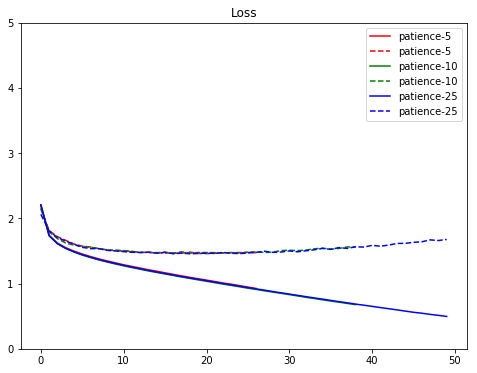

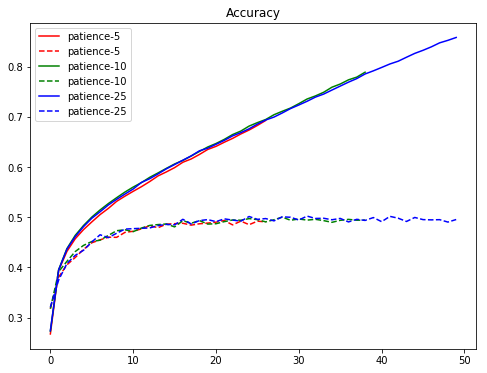

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

def drawing(results: dict):
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()
    
drawing(results)    

### Answer

- 改成monitor val_acc後，patience為5､10時，分別執行到第27､39次停止
- patience=25時，50個epoch全跑完，沒有發生early stop